# Mask R-CNN - Inspect Nucleus Trained Model

Code to test, debug, and evaluate the Mask R-CNN model.

In [13]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log

import nucleus

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "nuclei_datasets")

# Inference Configuration
config = nucleus.NucleusInferenceConfig()
config.display()

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

## Load Validation Dataset

In [5]:

# Change dataset to 'stage1_train' for mAP on training samples
# Load validation dataset
dataset = nucleus.NucleusDataset()
dataset.load_nucleus(DATASET_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 25
Classes: ['BG', 'nucleus']


## Load Model

In [6]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"

weights_path = 'logs/nucleus20190525T1833/mask_rcnn_nucleus_0004.h5'

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  logs/nucleus20190525T1833/mask_rcnn_nucleus_0004.h5
Re-starting from epoch 4


### Compute AP on Batch of Images

In [11]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
global_ap = []
for limit in range(5):
    AP = compute_batch_ap(dataset, dataset.image_ids[limit*5:(limit+1)*5+1])
    global_ap.append(AP)
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))



  0 [256 320   3]   AP: 0.12
  1 [256 320   3]   AP: 0.07
  2 [256 320   3]   AP: 0.20
  3 [1040 1388    3]   AP: 0.02
  4 [256 320   3]   AP: 0.08
Mean AP overa 5 images: 0.0997


In [84]:
# Plot mAP plots for training and testing samples
# training samples taken: 100
# test samples taken: 25

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def read_file(file, fields):
    arr = np.empty((0,fields), float)

    file = open(file, 'r')
    for line in file:
        arr_line = np.array(line.replace('[', '').replace(']', '').split(',')).reshape(-1, fields).astype(float)
        arr = np.append(arr, arr_line, axis = 0)
    file.close()

    data = pd.DataFrame(arr)
    data.columns = ['sample{}'.format(i) for i in range(1,fields+1)]
    data['mean_map'] = data.mean(axis = 1)
    return data

test_data = read_file('map_tracker_test.txt', 25)
train_data = read_file('map_tracker_train.txt', 100)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

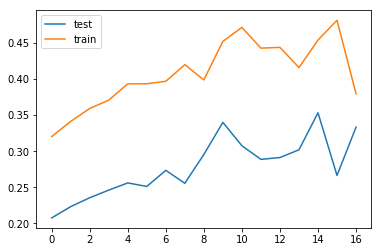

In [87]:
plt.plot(test_data.loc[:16, 'mean_map'], label = 'test')
plt.plot(train_data.loc[:16, 'mean_map'], label = 'train')
plt.legend(loc='upper left')
plt.plot

In [85]:
train_data.shape

(17, 101)